### Our Tasks & Output Data Analysis

In [930]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import t, norm

# reset display options
pd.reset_option("all")
# width of the display to max
pd.set_option('display.width', 1000)

def count_replication_count(wait_data: pd.DataFrame):
    """Counts the number of replications in the folder"""
    return wait_data["replication_no"].nunique()

def load_and_clean_queue_data(folder_path: str, queue_type: str):
    """Loads and processes bicycle or dock queue files (A to D)"""
    dfs = []
    for station in ['A', 'B', 'C', 'D']:
        filename = f"{queue_type}_queue_{station}.csv"
        filepath = Path(folder_path) / filename
        if filepath.exists():
            df = pd.read_csv(filepath)
            df["station"] = station
            df["queue_type"] = queue_type
            df["wait_time"] = df["curr_WaitTime"] - df["prev_WaitTime"]
            dfs.append(df[["replication_no", "id", "station", "queue_type", "wait_time"]])
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

def get_current_bicycle_and_dock_count(folder_path: str):
    """Get the current bicycle and dock count for each station"""
    docksize_file = Path(folder_path) / "docksize.csv"
    bicycles_count = 0
    docks_count = 0
    if docksize_file.exists():
        docksize_df = pd.read_csv(docksize_file)
        # 1st row skip header = availablebicycles + available docks
        docksize_df = docksize_df.iloc[0:]
        bicycles_count = int(docksize_df.iloc[0]["availablebicycles"]) + 1
        docks_count = int(docksize_df.iloc[0]["availabledock"]) + int(docksize_df.iloc[0]["availablebicycles"])
    return bicycles_count, docks_count

# Combine bicycle and dock queue data
def combine_all_queues(folder_path: str):
    bicycle_df = load_and_clean_queue_data(folder_path, "bicycle")
    dock_df = load_and_clean_queue_data(folder_path, "dock")
    combined = pd.concat([bicycle_df, dock_df], ignore_index=True)
    return combined

# Compute average waiting time per tourist per replication
def compute_per_tourist_avg_per_replication(wait_data: pd.DataFrame):
    non_zero = wait_data[wait_data["wait_time"] > 0]

    # Compute mean wait time over non-zero wait times
    avg_wait = non_zero.groupby(["id", "replication_no"])["wait_time"].mean().reset_index(name="avg_wait_time_per_tourist")

    # Now make sure all tourists (even those with only zeros) are present
    all_ids = wait_data[["id", "replication_no"]].drop_duplicates()
    result = all_ids.merge(avg_wait, on=["id", "replication_no"], how="left")

    # Fill NaN with 0 for those who had all wait_time == 0
    result["avg_wait_time_per_tourist"] = result["avg_wait_time_per_tourist"].fillna(0)

    return result

# Compute average waiting time per tourist per replication per station
def compute_per_tourist_avg_per_replication_per_station(wait_data: pd.DataFrame):
    return wait_data.groupby(["id", "replication_no", "station"])["wait_time"].mean().reset_index(name="avg_wait_time_per_tourist")

# Plot histogram and CDF
def plot_wait_distributions(per_tourist_df: pd.DataFrame):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(per_tourist_df["avg_wait_time_per_tourist"], bins=20, kde=True)
    plt.axvline(15, color='red', linestyle='--', label='Happy threshold (15 mins)')
    plt.title("Histogram of Average Wait Time per Tourist")
    plt.xlabel("Average Wait Time (minutes)")
    plt.ylabel("Number of Tourists")
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.ecdfplot(per_tourist_df["avg_wait_time_per_tourist"])
    plt.axvline(15, color='red', linestyle='--', label='Happy threshold (15 mins)')
    plt.title("CDF of Average Wait Time per Tourist")
    plt.xlabel("Average Wait Time (minutes)")
    plt.ylabel("Proportion of Tourists")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Compute per replication stats
def compute_per_replication_stats(wait_data: pd.DataFrame) -> pd.DataFrame:
    """Returns average waiting time, total arrival count, mean number of tourists waiting per replication"""
    grouped = wait_data.groupby("replication_no")
    avg_wait_time = grouped["avg_wait_time_per_tourist"].mean()
    total_arrival_count = grouped["id"].count()
    tourists_waiting = (
        grouped["avg_wait_time_per_tourist"]
        .apply(lambda x: (x > 0).sum())
    )
    mean_number_of_tourists_waiting = tourists_waiting / total_arrival_count
    
    result = pd.concat([
        total_arrival_count.rename("total_arrival_count"),
        mean_number_of_tourists_waiting.rename("mean_tourists_waiting"),
        avg_wait_time.rename("avg_wait_time_per_tourist"),
    ], axis=1)

    return result

# Compute confidence interval
def compute_confidence_interval(avg_waits: pd.Series, conf: float = 0.95, print_stats: bool = True):
    n = len(avg_waits)
    mean_x = avg_waits.mean()
    std_s = avg_waits.std(ddof=1)  # sample std dev
    alpha = 1 - conf

    # Degrees of freedom
    df = n - 1

    # t critical value for 95% CI
    t_crit = t.ppf(1 - alpha/2, df)

    # Margin of error
    margin = t_crit * (std_s / np.sqrt(n))

    # Confidence Interval
    conf_interval = (max(0, mean_x - margin), mean_x + margin)

    if print_stats:
        print(f"Sample Mean: {mean_x}")
        print(f"Sample Std Dev: {std_s}")
        print(f"t-critical (95%): {t_crit}")
        print(f"Margin of Error: {margin}")
        print(f"Confidence Interval: {conf_interval}")
    return conf_interval, mean_x, std_s, t_crit, margin

# Compute per tourist total wait time
def compute_per_tourist_total_wait_time(data: pd.DataFrame):
    return data.groupby(["id", "replication_no"])["wait_time"].sum().reset_index(name="total_wait_time")

# Compute required replications
def compute_required_replications(epsilon: float, confidence: float, std_s: float):
    """Computes the required number of replications to prove μ < 15 with desired accuracy (±1 min)"""
    Z_alpha_2 = norm.ppf(1 - (1 - confidence)/2)  # Z for two-tailed 95% CI ~ 1.96

    # Using the sample standard deviation from the 50-replication run
    S = std_s

    # Required sample size (replications) using normal approximation:
    # R ≥ (Z * S / ε)^2
    required_replications = (Z_alpha_2 * S / epsilon) ** 2

    required_replications_rounded = int(np.ceil(required_replications))

    return required_replications_rounded, Z_alpha_2


/var/folders/gt/d0m_mbpj3_s59cfmmr0pkgg80000gn/T/ipykernel_18787/2619861786.py:9: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option("all")


In [931]:
og_data_path = f"./data_80_80"
data_path = f"./data_60b_80d"

bicycle_count, dock_count = get_current_bicycle_and_dock_count(data_path)
print(f"Our System Total Bicycles: {bicycle_count}")
print(f"Our System Total Docks: {dock_count}")

Our System Total Bicycles: 60
Our System Total Docks: 80


In [932]:
# OG Bicycle & Dock Queue Data
og_df_bicycle_queue = load_and_clean_queue_data(og_data_path, "bicycle")
og_df_bicycle_queue.head()

# Bicycle Queue Data
df_bicycle_queue = load_and_clean_queue_data(data_path, "bicycle")
df_bicycle_queue.head()

,replication_no,id,station,queue_type,wait_time
0,1,11,A,bicycle,0.0
1,1,16,A,bicycle,0.0
2,1,21,A,bicycle,0.0
3,1,24,A,bicycle,0.0
4,1,14,A,bicycle,0.0


In [933]:
# unique values of replication_no
replication_count = count_replication_count(df_bicycle_queue)
print(f"Replication Count: {replication_count}")

Replication Count: 50


In [934]:
df_bicycle_queue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112914 entries, 0 to 112913
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   replication_no  112914 non-null  int64  
 1   id              112914 non-null  int64  
 2   station         112914 non-null  object 
 3   queue_type      112914 non-null  object 
 4   wait_time       112914 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.3+ MB


In [935]:
# OG Dock Queue Data
og_df_dock_queue = load_and_clean_queue_data(og_data_path, "dock")
og_df_dock_queue.head()

# Dock Queue Data
df_dock_queue = load_and_clean_queue_data(data_path, "dock")
df_dock_queue.head()

,replication_no,id,station,queue_type,wait_time
0,1,14,A,dock,0.0
1,1,22,A,dock,0.0
2,1,13,A,dock,0.0
3,1,31,A,dock,0.0
4,1,20,A,dock,0.0


In [936]:
df_dock_queue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112349 entries, 0 to 112348
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   replication_no  112349 non-null  int64  
 1   id              112349 non-null  int64  
 2   station         112349 non-null  object 
 3   queue_type      112349 non-null  object 
 4   wait_time       112349 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.3+ MB


In [937]:
# OG Data
og_data = pd.concat([og_df_bicycle_queue, og_df_dock_queue])
og_data.head()

# Our Model Data
data = pd.concat([df_bicycle_queue, df_dock_queue])
data.head()

,replication_no,id,station,queue_type,wait_time
0,1,11,A,bicycle,0.0
1,1,16,A,bicycle,0.0
2,1,21,A,bicycle,0.0
3,1,24,A,bicycle,0.0
4,1,14,A,bicycle,0.0


In [938]:
# tourist 1 & replication 2
data[(data["id"] == 11) & (data["replication_no"] == 1)]

,replication_no,id,station,queue_type,wait_time
0,1,11,A,bicycle,0.0
28541,1,11,B,bicycle,0.0
56835,1,11,C,bicycle,0.0
28110,1,11,B,dock,0.0
56515,1,11,C,dock,0.0
84592,1,11,D,dock,0.0


### Question 1:
The average waiting time for renting or returning a bicycle at each station? If tourists should not wait more than one hour in total (both for renting bikes and returning them), is the current system satisfactory?

In [939]:
# Per station analysis
per_tourist_per_station_df = compute_per_tourist_avg_per_replication_per_station(og_data)
per_tourist_per_station_df.head()

,id,replication_no,station,avg_wait_time_per_tourist
0,1,2,A,0.000000
1,1,2,B,2.998321
2,1,2,C,0.000000
3,1,2,D,0.000000
4,1,3,A,0.000000


In [940]:
# Any tourist should not wait more than 1 hour in total (both for renting bikes and returning them)

per_tourist_total_wait_time_df = compute_per_tourist_total_wait_time(og_data)
per_tourist_total_wait_time_df

,id,replication_no,total_wait_time
0,1,2,5.996642
1,1,3,0.000000
2,1,4,0.000000
3,1,5,9.925591
4,1,6,2.441270
...,...,...,...
38657,827,46,0.000000
38658,828,25,0.000000
38659,828,38,0.000000
38660,829,25,0.000000


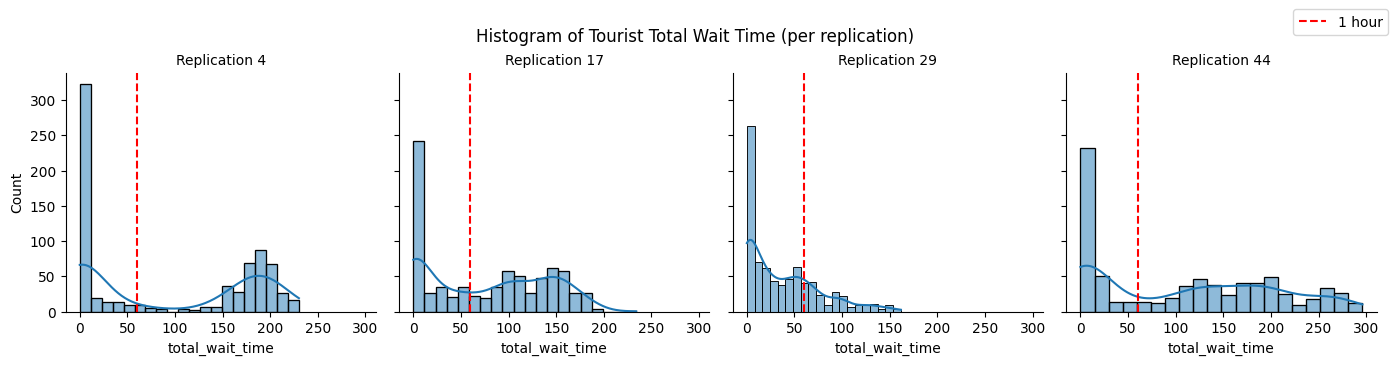

In [941]:
# Let's take few random replications and plot the histogram of tourist total wait time
# random 4 replications
random_replications = per_tourist_total_wait_time_df["replication_no"].sample(4).values
sample_df = per_tourist_total_wait_time_df[per_tourist_total_wait_time_df["replication_no"].isin(random_replications)]

def hist_with_vline(data, color=None, **kwargs):
    ax = plt.gca()
    sns.histplot(data["total_wait_time"], bins=20, kde=True, ax=ax, color=color)
    ax.axvline(60, color='red', linestyle='--', label='1 hour')

# Create and map
g = sns.FacetGrid(sample_df, col="replication_no", col_wrap=4, height=3.5, sharex=True, sharey=True)
g.map_dataframe(hist_with_vline)

# Add a 1 hour legend manually
handles, labels = g.axes[0].get_legend_handles_labels()
g.fig.legend(handles, labels, loc='upper right', ncol=3, bbox_to_anchor=(1, 1.05))

# Titles and layout
g.set_titles("Replication {col_name}")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Histogram of Tourist Total Wait Time (per replication)")

plt.show()


In [942]:
#### Confidence Interval
# Get confidence, on yes there is some tourist waiting time >= 1 hour

# Get max total waiting time by tourist per replication
max_total_time_per_tourist_per_replication = per_tourist_total_wait_time_df.groupby(["replication_no"])["total_wait_time"].max().reset_index(name="max_total_wait_time")
max_total_time_per_tourist_per_replication.head()

# Calculate confidence interval for max total waiting time at 95% confidence level
(
    confidence_interval_max_total_wait_time, 
    mean_x_max_total_wait_time, 
    std_s_max_total_wait_time, 
    t_crit_max_total_wait_time, 
    margin_max_total_wait_time
) = compute_confidence_interval(max_total_time_per_tourist_per_replication["max_total_wait_time"], conf=0.95, print_stats=False)

print("+++--- Confidence Interval for Total Waiting Time ---+++")
print(f"    Sample Mean: {mean_x_max_total_wait_time} mins (i.e. {round(mean_x_max_total_wait_time/60, 2)} hrs)")
print(f"    Sample Std Dev: {std_s_max_total_wait_time} mins (i.e. {round(std_s_max_total_wait_time/60, 2)} hrs)")
print(f"    t-critical (95%): {t_crit_max_total_wait_time}")
print(f"    Margin of Error: {margin_max_total_wait_time} mins")
print(f"    Confidence Interval: {confidence_interval_max_total_wait_time} (mins) (i.e. {round(confidence_interval_max_total_wait_time[0]/60, 2)} hrs to {round(confidence_interval_max_total_wait_time[1]/60, 2)} hrs)")
print("+++--- End of Confidence Interval for Total Waiting Time ---+++")

+++--- Confidence Interval for Total Waiting Time ---+++
    Sample Mean: 270.38714433999996 mins (i.e. 4.51 hrs)
    Sample Std Dev: 72.83155541204395 mins (i.e. 1.21 hrs)
    t-critical (95%): 2.0095752371292392
    Margin of Error: 20.698499028965898 mins
    Confidence Interval: (249.68864531103407, 291.08564336896586) (mins) (i.e. 4.16 hrs to 4.85 hrs)
+++--- End of Confidence Interval for Total Waiting Time ---+++


In [943]:
# Compute required replications

# Get OG data replication count
replication_count = count_replication_count(og_data)

epsilon = 1  # desired margin of error (±1 min)
required_replications_rounded, Z_alpha_2 = compute_required_replications(epsilon, 0.95, std_s_max_total_wait_time)
print("+++--- Required Replications ---+++")
print(f"    Desired Accuracy (±ε): {epsilon} mins")
print(f"    Current Replication Count: {replication_count}")
print(f"    Required Replications: {required_replications_rounded} for 95% confidence")
print(f"    Z-critical (95%): {Z_alpha_2}")
print("+++--- End of Required Replications ---+++")


+++--- Required Replications ---+++
    Desired Accuracy (±ε): 1 mins
    Current Replication Count: 50
    Required Replications: 20377 for 95% confidence
    Z-critical (95%): 1.959963984540054
+++--- End of Required Replications ---+++


In [944]:
# Check if there is any tourist waiting time >= 1 hour
is_any_tourist_waiting_more_than_1_hour = per_tourist_total_wait_time_df["total_wait_time"].gt(60).any()
is_any_tourist_waiting_more_than_1_hour

print("+++--- Conclusion ---+++")
if is_any_tourist_waiting_more_than_1_hour:
    print("Yes, there are tourists waiting more than 1 hour in total (both for renting bikes and returning them).")
    print("*** So, System is not satisfactory. ***")
else:
    print("No, there are no tourists waiting more than 1 hour in total (both for renting bikes and returning them).")
    print("*** So, System is satisfactory. ***")

+++--- Conclusion ---+++
Yes, there are tourists waiting more than 1 hour in total (both for renting bikes and returning them).
*** So, System is not satisfactory. ***


In [945]:
# The average waiting time for renting or returning a bicycle at each station?

# Station A
station_a_df = per_tourist_per_station_df[per_tourist_per_station_df["station"] == "A"]
station_a_per_replication_stats = compute_per_replication_stats(station_a_df)
print("-" * 100)
print("Station A Per Replication Stats:")
print("-" * 100)
print(station_a_per_replication_stats)
# Station B
station_b_df = per_tourist_per_station_df[per_tourist_per_station_df["station"] == "B"]
station_b_per_replication_stats = compute_per_replication_stats(station_b_df)
print("-" * 100)
print("Station B Per Replication Stats:")
print("-" * 100)
print(station_b_per_replication_stats.head())
# Station C
station_c_df = per_tourist_per_station_df[per_tourist_per_station_df["station"] == "C"]
station_c_per_replication_stats = compute_per_replication_stats(station_c_df)
print("-" * 100)
print("Station C Per Replication Stats:")
print("-" * 100)
print(station_c_per_replication_stats.head())
# Station D
station_d_df = per_tourist_per_station_df[per_tourist_per_station_df["station"] == "D"]
station_d_per_replication_stats = compute_per_replication_stats(station_d_df)
print("-" * 100)
print("Station D Per Replication Stats:")
print("-" * 100)
print(station_d_per_replication_stats.head())


----------------------------------------------------------------------------------------------------
Station A Per Replication Stats:
----------------------------------------------------------------------------------------------------
                total_arrival_count  mean_tourists_waiting  avg_wait_time_per_tourist
replication_no                                                                       
1                               690               0.000000                   0.000000
2                               688               0.475291                  11.749906
3                               647               0.340031                  27.124262
4                               657               0.071537                   1.012035
5                               674               0.151335                   4.464750
6                               723               0.114799                   1.299829
7                               704               0.005682                   

In [946]:
# Average waiting time per station
# Station A
station_a_avg_wait_time = station_a_per_replication_stats["avg_wait_time_per_tourist"].mean()
confidence_interval_a, mean_x_a, std_s_a, t_crit_a, margin_a = compute_confidence_interval(station_a_per_replication_stats["avg_wait_time_per_tourist"], print_stats=False)
# Station B
station_b_avg_wait_time = station_b_per_replication_stats["avg_wait_time_per_tourist"].mean()
confidence_interval_b, mean_x_b, std_s_b, t_crit_b, margin_b = compute_confidence_interval(station_b_per_replication_stats["avg_wait_time_per_tourist"], print_stats=False)
# Station C
station_c_avg_wait_time = station_c_per_replication_stats["avg_wait_time_per_tourist"].mean()
confidence_interval_c, mean_x_c, std_s_c, t_crit_c, margin_c = compute_confidence_interval(station_c_per_replication_stats["avg_wait_time_per_tourist"], print_stats=False)
# Station D
station_d_avg_wait_time = station_d_per_replication_stats["avg_wait_time_per_tourist"].mean()
confidence_interval_d, mean_x_d, std_s_d, t_crit_d, margin_d = compute_confidence_interval(station_d_per_replication_stats["avg_wait_time_per_tourist"], print_stats=False)

print("-" * 100)
print("Average Waiting Time per Station:")
print("-" * 100)
print(f"Station A:")
print(f"    Average Waiting Time: {station_a_avg_wait_time} mins")
print(f"    Confidence Interval: {confidence_interval_a}")
print(f"Station B:")
print(f"    Average Waiting Time: {station_b_avg_wait_time} mins")
print(f"    Confidence Interval: {confidence_interval_b}")
print(f"Station C:")
print(f"    Average Waiting Time: {station_c_avg_wait_time} mins")
print(f"    Confidence Interval: {confidence_interval_c}")
print(f"Station D: {station_d_avg_wait_time} mins")
print(f"    Confidence Interval: {confidence_interval_d}")

----------------------------------------------------------------------------------------------------
Average Waiting Time per Station:
----------------------------------------------------------------------------------------------------
Station A:
    Average Waiting Time: 5.518849489006018 mins
    Confidence Interval: (1.467890890764135, 9.569808087247901)
Station B:
    Average Waiting Time: 19.380868597187874 mins
    Confidence Interval: (12.516520146696596, 26.24521704767915)
Station C:
    Average Waiting Time: 25.42203402071693 mins
    Confidence Interval: (17.27386614240133, 33.570201899032526)
Station D: 12.158900645001772 mins
    Confidence Interval: (5.826968253150517, 18.490833036853026)


### Question 2:
* Keep **80%** tourists feel **HAPPY!!** (i.e. below 15 mins)
* at the same tome, minimize their cost of building docks and buying the bicycles at the stations

In [947]:
# So, let's analyze entier model (i.e. all stations together)

# get aggregate data per tourist per replication & get average waiting time per tourist per replication
per_tourist_df = compute_per_tourist_avg_per_replication(data)
per_tourist_df.head()

,id,replication_no,avg_wait_time_per_tourist
0,11,1,0.0
1,16,1,0.0
2,21,1,0.0
3,24,1,0.0
4,14,1,0.0


In [948]:
# Get the all stats per replication
per_replication_stats = compute_per_replication_stats(per_tourist_df)
per_replication_stats.head()

,total_arrival_count,mean_tourists_waiting,avg_wait_time_per_tourist
replication_no,,,
1,750,0.189333,18.560108
2,807,0.166047,3.076692
3,784,0.170918,1.622774
4,775,0.000000,0.000000
5,832,0.126202,5.374261


In [949]:
# tourist 11 & replication 1
per_tourist_df[(per_tourist_df["id"] == 11) & (per_tourist_df["replication_no"] == 1)]

,id,replication_no,avg_wait_time_per_tourist
0,11,1,0.0


In [950]:
# Maximum & Minimum waiting time per tourist per replication
max_wait_time_row = per_tourist_df[per_tourist_df["avg_wait_time_per_tourist"] == per_tourist_df["avg_wait_time_per_tourist"].max()]
min_wait_time_row = per_tourist_df[per_tourist_df["avg_wait_time_per_tourist"] == per_tourist_df["avg_wait_time_per_tourist"].min()]

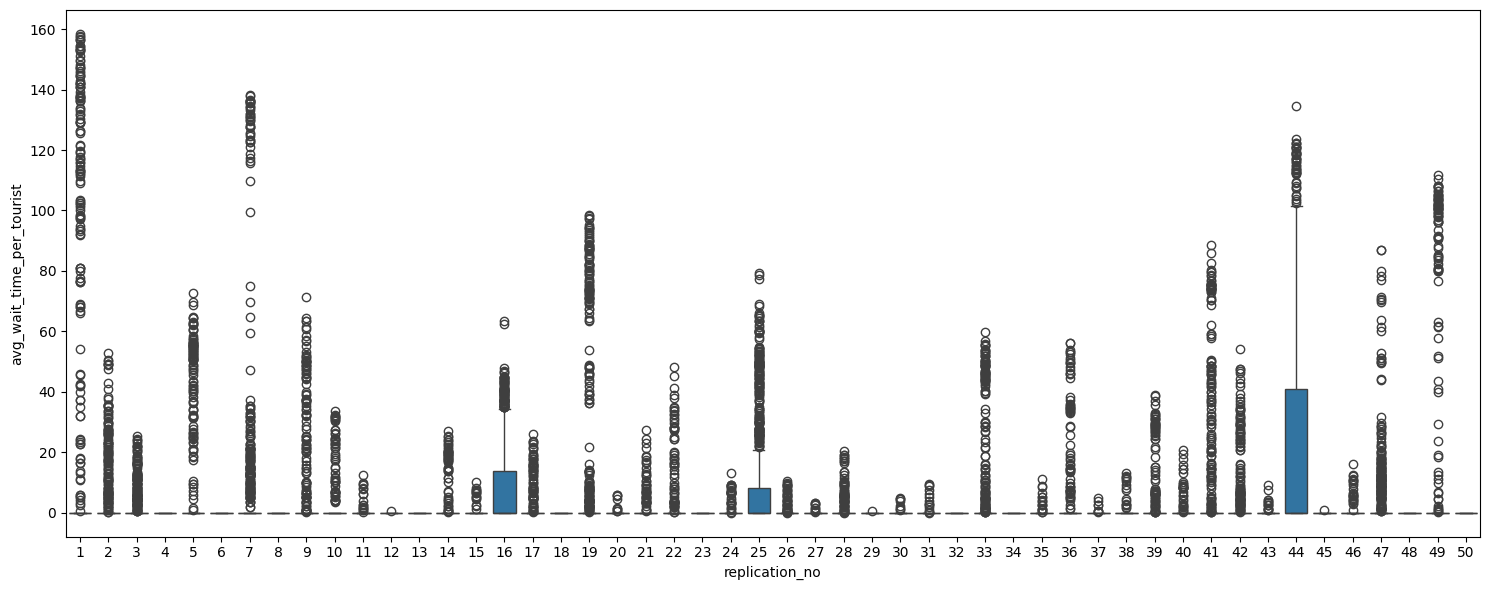

+++--- Quick Summary ---+++
Best Case Scenario:
    Minimum avg waiting time: 0.0 mins at Replication 1
Worst Case Scenario:
    Maximum avg waiting time: 158.429023 mins at Replication 1
+++--- End of Quick Summary ---+++


In [951]:
# Boxplot of tourists waiting time per replication
plt.figure(figsize=(15, 6))
sns.boxplot(x="replication_no", y="avg_wait_time_per_tourist", data=per_tourist_df)
plt.tight_layout()
plt.show()

print("+++--- Quick Summary ---+++")
print(f"Best Case Scenario:")
print(f"    Minimum avg waiting time: {min_wait_time_row['avg_wait_time_per_tourist'].values[0]} mins at Replication {min_wait_time_row['replication_no'].values[0]}")
print(f"Worst Case Scenario:")
print(f"    Maximum avg waiting time: {max_wait_time_row['avg_wait_time_per_tourist'].values[0]} mins at Replication {max_wait_time_row['replication_no'].values[0]}")
print("+++--- End of Quick Summary ---+++")


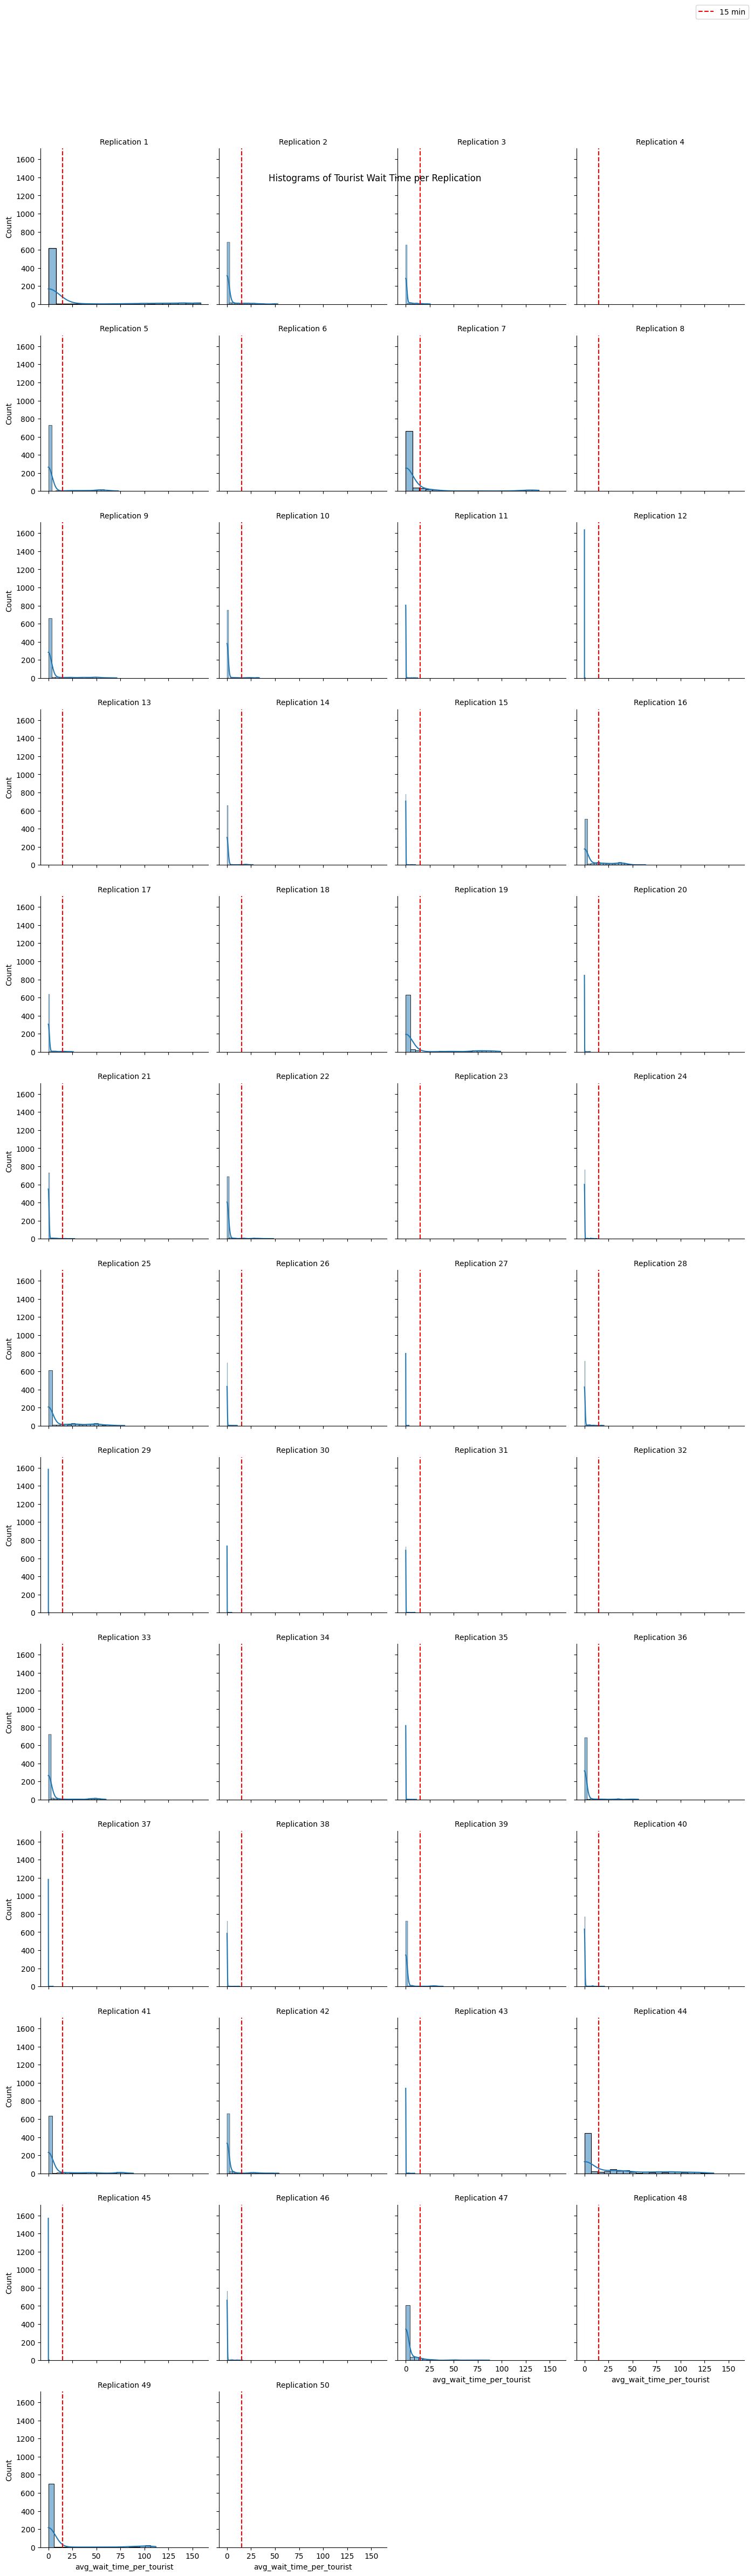

In [952]:
# Custom plot function with 15min vertical lines
def hist_with_vlines(data, color=None, **kwargs):
    ax = plt.gca()
    sns.histplot(data["avg_wait_time_per_tourist"], bins=20, kde=True, ax=ax, color=color)
    ax.axvline(15, color='red', linestyle='--', label='15 min')
    ax.legend(loc='upper right', fontsize='small')

# Create the FacetGrid
g = sns.FacetGrid(per_tourist_df, col="replication_no", col_wrap=4, height=3.5, sharex=True, sharey=True)

# Apply the custom plotting function to each facet
g.map_dataframe(hist_with_vlines)

# Add a 1 hour legend manually
handles, labels = g.axes[0].get_legend_handles_labels()
g.fig.legend(handles, labels, loc='upper right', ncol=3, bbox_to_anchor=(1, 1.05))

# Titles and layout
g.set_titles("Replication {col_name}")
g.fig.subplots_adjust(top=0.99)
g.fig.suptitle("Histograms of Tourist Wait Time per Replication")

plt.show()

In [953]:
# Get the mean waiting time per replication
replication_means = per_replication_stats["avg_wait_time_per_tourist"]
replication_means

replication_no
1     18.560108
2      3.076692
3      1.622774
4      0.000000
5      5.374261
6      0.000000
7      9.011035
8      0.000000
9      4.146898
10     1.173691
11     0.106358
12     0.000785
13     0.000000
14     1.071903
15     0.109074
16     8.364992
17     1.140081
18     0.000000
19     9.723837
20     0.035054
21     0.555482
22     1.469725
23     0.000000
24     0.219853
25     9.485433
26     0.251221
27     0.021436
28     0.618416
29     0.000548
30     0.032526
31     0.083388
32     0.000000
33     4.140863
34     0.000000
35     0.090986
36     2.325500
37     0.019098
38     0.155440
39     1.554669
40     0.315650
41     6.586887
42     2.488347
43     0.063795
44    24.896114
45     0.001137
46     0.221002
47     3.970882
48     0.000000
49     8.971328
50     0.000000
Name: avg_wait_time_per_tourist, dtype: float64

### Point and interval estimates

#### 1. Point Estimate Calculations

In [954]:
# Mean (Point Estimate)
wait_time_mean = replication_means.mean()
wait_time_mean
print(f"Mean Waiting Time: {wait_time_mean} mins")

Mean Waiting Time: 2.641145374682615 mins


In [955]:
# Variance (Point Estimate)
wait_time_variance = replication_means.var()
wait_time_variance
print(f"Variance of Waiting Time: {wait_time_variance} mins^2")

Variance of Waiting Time: 24.228555577556914 mins^2


#### 2. Confidence Interval

In [956]:
# 95% CI
alpha = 0.05
confidence_level = 1 - alpha
# Calculate confidence interval with 95% confidence level
confidence_interval, mean_x, std_s, t_crit, margin = compute_confidence_interval(replication_means, confidence_level)

Sample Mean: 2.641145374682615
Sample Std Dev: 4.922251068114762
t-critical (95%): 2.0095752371292392
Margin of Error: 1.398888275518713
Confidence Interval: (1.242257099163902, 4.0400336502013285)


### Hypothesis Testing

Both directions of hypothesis testing — **proving ≤ 15 mins** and **ensuring it’s not > 15 mins**:

### 💡 TL;DR
- We **cannot claim** that our system is **statistically better than 15 mins**.
- But we **can safely say** it’s **not proven to be worse** than 15 mins either.

In [957]:
# Hypothesis Test:
# H0: mu <= 15 (average wait time is acceptable)
# H1: mu > 15 (average wait time is too high)

mu_0 = 15  # Target threshold for average waiting time
n = len(replication_means)
df = n - 1

# Confidence interval (two-sided)
t_critical_two_sided = t.ppf(1 - alpha/2, df)
margin = t_critical_two_sided * (std_s / np.sqrt(n))
confidence_interval = (mean_x - margin, mean_x + margin)

# One-sided left-tailed test: H0: mu >= 15 vs H1: mu < 15 (prove system is good enough)
t_statistic = (mean_x - mu_0) / (std_s / np.sqrt(n))
t_critical_left = t.ppf(alpha, df)
reject_H0_mu_gte_15 = t_statistic < t_critical_left

# One-sided right-tailed test: H0: mu <= 15 vs H1: mu > 15 (prove system is NOT good enough)
t_critical_right = t.ppf(1 - alpha, df)
reject_H0_mu_lte_15 = t_statistic > t_critical_right

# Dynamic interpretation messages
if reject_H0_mu_gte_15:
    conclusion_left = "✅ There is statistically significant evidence (95% confidence) that the average waiting time is less than 15 minutes."
else:
    conclusion_left = "❌ Cannot conclude with 95% confidence that the average waiting time is less than 15 minutes."

if reject_H0_mu_lte_15:
    conclusion_right = "⚠️ There is statistically significant evidence (95% confidence) that the average waiting time exceeds 15 minutes."
else:
    conclusion_right = "✅ There is no statistical evidence that the average waiting time exceeds 15 minutes."

print("+++--- Hypothesis Test Results ---+++")
print(f"Sample Mean: {mean_x}")
print(f"Sample Std Dev: {std_s}")
print(f"95% CI: {confidence_interval}")
print(f"Margin of Error: {margin}")
print(f"t-statistic: {t_statistic}")
print(f"Left-tailed test H0: μ ≥ 15 → H1: μ < 15")
print(f"    t-critical: {t_critical_left}")
print(f"    Reject H0?: {reject_H0_mu_gte_15}")
print(f"    Conclusion: {conclusion_left}")
print(f"Right-tailed test H0: μ ≤ 15 → H1: μ > 15")
print(f"    t-critical: {t_critical_right}")
print(f"    Reject H0?: {reject_H0_mu_lte_15}")
print(f"    Conclusion: {conclusion_right}")
print("+++--- End of Hypothesis Test Results ---+++")

+++--- Hypothesis Test Results ---+++
Sample Mean: 2.641145374682615
Sample Std Dev: 4.922251068114762
95% CI: (1.242257099163902, 4.0400336502013285)
Margin of Error: 1.398888275518713
t-statistic: -17.754132798853203
Left-tailed test H0: μ ≥ 15 → H1: μ < 15
    t-critical: -1.6765508926168542
    Reject H0?: True
    Conclusion: ✅ There is statistically significant evidence (95% confidence) that the average waiting time is less than 15 minutes.
Right-tailed test H0: μ ≤ 15 → H1: μ > 15
    t-critical: 1.6765508926168535
    Reject H0?: False
    Conclusion: ✅ There is no statistical evidence that the average waiting time exceeds 15 minutes.
+++--- End of Hypothesis Test Results ---+++


So then **how many replications** you'd need to prove **μ < 15** with desired accuracy (e.g., ±1 min)?

In [958]:
# Parameters
epsilon = 1  # desired margin of error (±1 min)
required_replications_rounded, Z_alpha_2 = compute_required_replications(epsilon, confidence_level, std_s)

print("+++--- Required Replications ---+++")
print("Desired Accuracy (±ε):", epsilon)
print("Z-critical (95%):", Z_alpha_2)
print("Sample Std Dev (S):", std_s)
print("Required Replications (rounded up):", required_replications_rounded)
print("+++--- End of Required Replications ---+++")
print("** Final Conclusion: **")
print(f"    We would need at least {required_replications_rounded} replications to prove μ < 15 with desired accuracy (±1 min).")

+++--- Required Replications ---+++
Desired Accuracy (±ε): 1
Z-critical (95%): 1.959963984540054
Sample Std Dev (S): 4.922251068114762
Required Replications (rounded up): 94
+++--- End of Required Replications ---+++
** Final Conclusion: **
    We would need at least 94 replications to prove μ < 15 with desired accuracy (±1 min).


#### Overal Final Output Data Analysis Stats

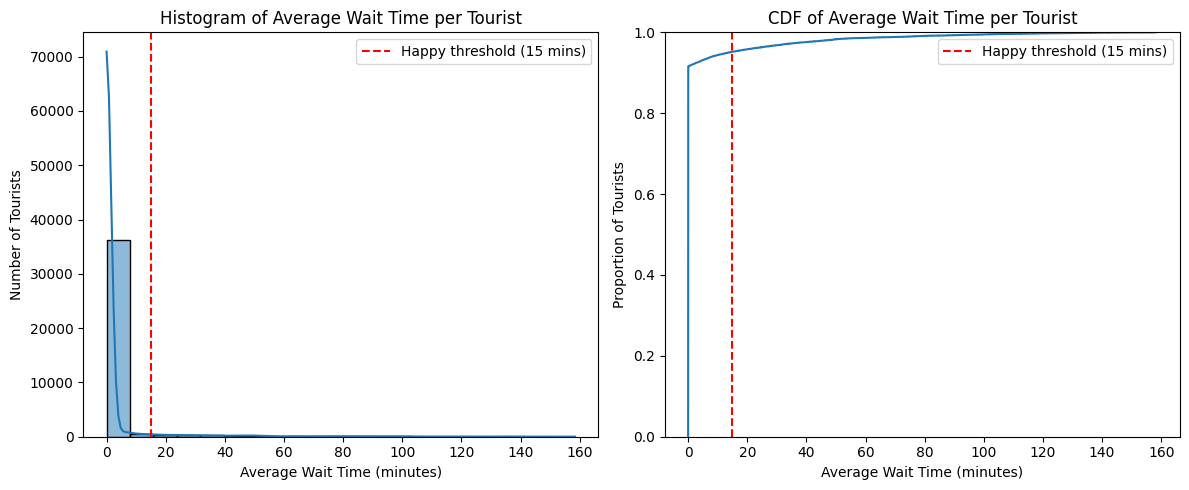

+++--- Output Data Analysis ---+++
--------------------------------
Summary Average Wait Time of the our model:
--------------------------------
Maximum Waiting Time: 158.429023 mins (2.64 hrs) at Replication 1
Point Estimates:
    Sample Std Dev: 4.922251068114762
    Sample Mean: 2.641145374682615
Interval Estimates:
    t-critical (95%): 2.0095752371292392
    Margin of Error: 1.398888275518713
    Confidence Interval: (1.242257099163902, 4.0400336502013285)
Customer Satisfaction:
    % Happy Tourists (<15 mins): 95.2%
    % Unhappy Tourists (>60 mins): 1.37%
--------------------------------
Hypothesis Test Results:
--------------------------------
    t-statistic: -17.754132798853203
    Left-tailed test H0: μ ≥ 15 → H1: μ < 15
        t-critical: -1.6765508926168542
        Reject H0?: True
        Conclusion: ✅ There is statistically significant evidence (95% confidence) that the average waiting time is less than 15 minutes.
    Right-tailed test H0: μ ≤ 15 → H1: μ > 15
        t

In [959]:
# happy tourists
happy_pct = per_tourist_df["avg_wait_time_per_tourist"].lt(15).mean() * 100
over_60_pct = per_tourist_df["avg_wait_time_per_tourist"].gt(60).mean() * 100

plot_wait_distributions(per_tourist_df)

# 80% happy tourists
required_happy_pct = 80

# Costs (per unit)
bicycle_cost = 80
dock_cost = 100

# Current System
current_system_bicycle_count = 80
current_system_dock_count = 80
current_system_cost = current_system_bicycle_count * bicycle_cost + current_system_dock_count * dock_cost

# Our System
our_system_bicycle_count = bicycle_count
our_system_dock_count = dock_count
our_system_cost = our_system_bicycle_count * bicycle_cost + our_system_dock_count * dock_cost

# Additional Cost
additional_cost = (our_system_bicycle_count - current_system_bicycle_count) * bicycle_cost + (our_system_dock_count - current_system_dock_count) * dock_cost
total_cost = current_system_cost + additional_cost

print("+++--- Output Data Analysis ---+++")
print("--------------------------------")
print("Summary Average Wait Time of the our model:")
print("--------------------------------")
print(f"Maximum Waiting Time: {max_wait_time_row['avg_wait_time_per_tourist'].values[0]} mins ({round(max_wait_time_row['avg_wait_time_per_tourist'].values[0] / 60, 2)} hrs) at Replication {max_wait_time_row['replication_no'].values[0]}")
print("Point Estimates:")
print(f"    Sample Std Dev: {std_s}")
print(f"    Sample Mean: {mean_x}")
print("Interval Estimates:")
print(f"    t-critical (95%): {t_crit}")
print(f"    Margin of Error: {margin}")
print(f"    Confidence Interval: {confidence_interval}")
print("Customer Satisfaction:")
print(f"    % Happy Tourists (<15 mins): {round(happy_pct, 2)}%")
print(f"    % Unhappy Tourists (>60 mins): {round(over_60_pct, 2)}%")
print("--------------------------------")
print("Hypothesis Test Results:")
print("--------------------------------")
print(f"    t-statistic: {t_statistic}")
print(f"    Left-tailed test H0: μ ≥ 15 → H1: μ < 15")
print(f"        t-critical: {t_critical_left}")
print(f"        Reject H0?: {reject_H0_mu_gte_15}")
print(f"        Conclusion: {conclusion_left}")
print(f"    Right-tailed test H0: μ ≤ 15 → H1: μ > 15")
print(f"        t-critical: {t_critical_right}")
print(f"        Reject H0?: {reject_H0_mu_lte_15}")
print(f"        Conclusion: {conclusion_right}")
print("--------------------------------")
print("Required Replications:")
print("--------------------------------")
print(f"    Desired Accuracy (±ε): {epsilon} mins")
print(f"    Z-critical (95%): {Z_alpha_2}")
print(f"    Sample Std Dev (S): {S} mins")
print(f"    Current Replication Count: {replication_count}")
print(f"    Required Replications (rounded up): {required_replications_rounded} for 95% confidence")
print("--------------------------------")
print(f"Cost Analysis: *** Additional Cost: ${additional_cost:,} ***")
print("--------------------------------")
print(f"    Total Bicycles: {bicycle_count}")
print(f"    Total Docks: {dock_count}")
print(f"    Current System Cost: ${current_system_cost:,}")
print(f"    Our System Cost: ${our_system_cost:,}")
print("--------------------------------")
print("+++--- End of Output Data Analysis ---+++")
print("")

#### Final Result & Conclusion

In [960]:
print("*** Result ***")
print(f"Total Cost of ${total_cost:,} with {bicycle_count} bicycles and {dock_count} docks")
print(f"Current System Analysis:")
if current_system_bicycle_count > bicycle_count:
    print(f"    we have removed {current_system_bicycle_count - bicycle_count} bicycles from the system, resulting in ${(current_system_bicycle_count - bicycle_count) * bicycle_cost} saved")
else:
    print(f"    we have added {bicycle_count - current_system_bicycle_count} bicycles to the system, resulting in ${(bicycle_count - current_system_bicycle_count) * bicycle_cost} of additional cost")
if current_system_dock_count > dock_count:
    print(f"    we have removed {current_system_dock_count - dock_count} docks from the system, resulting in ${(current_system_dock_count - dock_count) * dock_cost} saved")
else:
    print(f"    we have added {dock_count - current_system_dock_count} docks to the system, resulting in ${(dock_count - current_system_dock_count) * dock_cost} of additional cost")

print(f"Achieved Happy Percentage: {round(happy_pct, 2)}%")
if happy_pct >= required_happy_pct:
    print(f"    So, we have already achieved {round(happy_pct, 2)}% happy tourists!! Hurray!!")
else:
    print(f"    So, we need to reduce additional {round(required_happy_pct - happy_pct, 2)}% of tourists waiting time to achieve {required_happy_pct}% happy tourists")

print(f"Max Waiting Time: {max_wait_time_row['avg_wait_time_per_tourist'].values[0]} mins ({round(max_wait_time_row['avg_wait_time_per_tourist'].values[0] / 60, 2)} hrs) at Replication {max_wait_time_row['replication_no'].values[0]}")
if max_wait_time_row['avg_wait_time_per_tourist'].values[0] > 60:
    print(f"    Current System is NOT satisfactory!")
    print(f"    So, we need to reduce the max waiting time by {round(max_wait_time_row['avg_wait_time_per_tourist'].values[0] - 60, 2)} mins")
else:
    print(f"    Current System is satisfactory!!!")
    print(f"    So, we need to reduce the max waiting time by {round(max_wait_time_row['avg_wait_time_per_tourist'].values[0] - 60, 2)} mins")

print("*** End of Result ***")


*** Result ***
Total Cost of $12,800 with 60 bicycles and 80 docks
Current System Analysis:
    we have removed 20 bicycles from the system, resulting in $1600 saved
    we have added 0 docks to the system, resulting in $0 of additional cost
Achieved Happy Percentage: 95.2%
    So, we have already achieved 95.2% happy tourists!! Hurray!!
Max Waiting Time: 158.429023 mins (2.64 hrs) at Replication 1
    Current System is NOT satisfactory!
    So, we need to reduce the max waiting time by 98.43 mins
*** End of Result ***
